In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import pdb

# supporting:

sys.path.insert(0,'..')
from config import global_config
from dataset import LaneNetDataset
from model import lanenet_model
from utils import preprocess_rgb

## Training process:

Loading data (batches) from dataloader

In [2]:
training_file = '/home/ubuntu/dev/LaneNet-Pytorch/data/training_data/train.txt'
CFG = global_config.cfg

In [3]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

dataset = LaneNetDataset(training_file, CFG, transform)

In [4]:
# split data into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=CFG.TRAIN.BATCH_SIZE, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=CFG.TRAIN.VAL_BATCH_SIZE, 
                                          shuffle=False)

In [13]:
model = lanenet_model.LaneNet().cuda()

# Check if vgg params are frozen
# for param in model.parameters():
#     print(param.requires_grad)

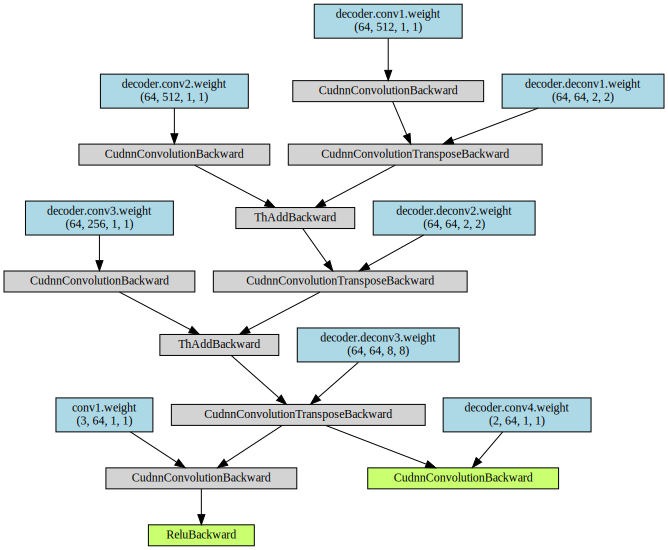

In [7]:
# visualize model

from torchviz import make_dot
inputs = next(iter(dataset))
src = inputs[0].unsqueeze(0).cuda()
make_dot(model(src), params=dict(model.named_parameters()))

In [8]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.TRAIN.LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [9]:
model.train()

total_step = len(train_loader)
inc = int(total_step / 16)
for epoch in range(1):
    
    scheduler.step()
    
    for i, (src, binary, instance) in enumerate(train_loader):
        
        # dataloader automatically converts to tensor
#         print(src.shape)
#         print(binary.shape)
#         print(instance.shape)
        
        # send to gpu
        src = src.cuda()
        binary = binary.cuda()
        instance = instance.cuda()
        
        # Forward pass
        total_loss, binary_segmentation_loss, pix_embedding, disc_loss = model.compute_loss(src, binary, instance)
        
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if (i+1) % inc == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, CFG.TRAIN.EPOCHS, i+1, total_step, total_loss.cpu().item()))
    
    
    # validation

Epoch [1/1000], Step [45/725], Loss: 0.1482
Epoch [1/1000], Step [90/725], Loss: 0.0973
Epoch [1/1000], Step [135/725], Loss: 0.0802
Epoch [1/1000], Step [180/725], Loss: 0.0794
Epoch [1/1000], Step [225/725], Loss: 0.0694
Epoch [1/1000], Step [270/725], Loss: 0.0678
Epoch [1/1000], Step [315/725], Loss: 0.0625
Epoch [1/1000], Step [360/725], Loss: 0.0681
Epoch [1/1000], Step [405/725], Loss: 0.0693
Epoch [1/1000], Step [450/725], Loss: 0.0614
Epoch [1/1000], Step [495/725], Loss: 0.0634
Epoch [1/1000], Step [540/725], Loss: 0.0637
Epoch [1/1000], Step [585/725], Loss: 0.0595
Epoch [1/1000], Step [630/725], Loss: 0.0579
Epoch [1/1000], Step [675/725], Loss: 0.0599
Epoch [1/1000], Step [720/725], Loss: 0.0654
